In [21]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [22]:
#data = pd.read_csv("../input/bioresponse/train.csv")
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Уменьшим кол-во признаков, так как их слишком много

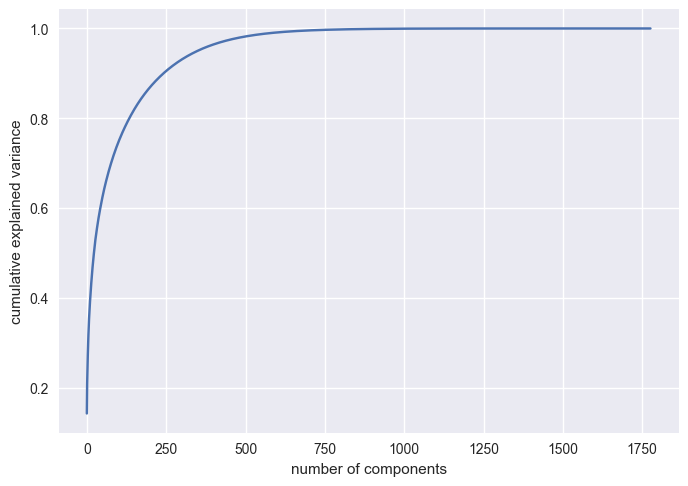

In [23]:
pca = PCA().fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

750 нам будет достаточно для полнценного описания

In [24]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

selector = SelectKBest(f_regression, k=750)
selector.fit(X, y)
 
X = selector.transform(X)

---

## <center> LogisticRegression

Обучаем модели логистической регрессии. Подбираем гиперпараметры с помощью базовых и продвинутых методов оптимизации. Максимальное количество итераций не превышает 50.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### <center> GridSearchCV

In [26]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg'], # алгоритм оптимизации
               'C': np.arange(0.01, 1, 0.1)}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': np.arange(0.01, 1, 0.1)}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 1.03 s
Wall time: 20.9 s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.788
Наилучшие значения гиперпараметров: {'C': 0.21000000000000002, 'penalty': 'l2', 'solver': 'lbfgs'}


c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\b

### <center> RandomizedSearchCV

In [27]:
param_distributions = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg'], # алгоритм оптимизации
               'C': np.arange(0.01, 1, 0.1)}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': np.arange(0.01, 1, 0.1)}
]
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 641 ms
Wall time: 11 s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.788
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.21000000000000002}


c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ba

### <center> Hyperopt

In [28]:
# зададим пространство поиска гиперпараметров
pen = ['l1', 'l2']
sol = ['liblinear', 'saga']
space={'penalty': hp.choice('penalty', ['l1', 'l2']), # тип регуляризации
       'solver': hp.choice('solver', ['liblinear', 'saga']), # алгоритм оптимизации
       'C': hp.uniform('C', low=0.01, high=1) # уровень силы регурялизации
      }

# зафксируем random_state
random_state = 42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
              'C': float(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [29]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  2%|▏         | 1/50 [00:00<00:17,  2.74trial/s, best loss: -0.7767986703881459]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  6%|▌         | 3/50 [00:04<01:02,  1.33s/trial, best loss: -0.7798036015647992]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 5/50 [00:07<01:05,  1.46s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 6/50 [00:10<01:20,  1.83s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 18%|█▊        | 9/50 [00:13<00:50,  1.22s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 22%|██▏       | 11/50 [00:17<00:54,  1.39s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 13/50 [00:20<00:51,  1.40s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 28%|██▊       | 14/50 [00:24<01:12,  2.01s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 32%|███▏      | 16/50 [00:28<01:03,  1.86s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▍      | 17/50 [00:30<01:07,  2.06s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 36%|███▌      | 18/50 [00:34<01:17,  2.43s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 44%|████▍     | 22/50 [00:38<00:32,  1.18s/trial, best loss: -0.7843994792274138]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 25/50 [00:41<00:23,  1.07trial/s, best loss: -0.7845917208966752]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 52%|█████▏    | 26/50 [00:44<00:36,  1.51s/trial, best loss: -0.7845917208966752]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 58%|█████▊    | 29/50 [00:47<00:22,  1.08s/trial, best loss: -0.7845917208966752]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 30/50 [00:50<00:30,  1.54s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 31/50 [00:53<00:35,  1.86s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 64%|██████▍   | 32/50 [00:55<00:37,  2.10s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 66%|██████▌   | 33/50 [00:58<00:38,  2.26s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 68%|██████▊   | 34/50 [01:01<00:37,  2.37s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 35/50 [01:03<00:36,  2.42s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 72%|███████▏  | 36/50 [01:06<00:34,  2.46s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 74%|███████▍  | 37/50 [01:08<00:33,  2.56s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 78%|███████▊  | 39/50 [01:14<00:28,  2.57s/trial, best loss: -0.7849023547026058]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|████████  | 40/50 [01:16<00:25,  2.59s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 82%|████████▏ | 41/50 [01:19<00:23,  2.58s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 42/50 [01:21<00:20,  2.60s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 86%|████████▌ | 43/50 [01:24<00:18,  2.64s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 88%|████████▊ | 44/50 [01:27<00:15,  2.62s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 45/50 [01:30<00:14,  2.84s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 46/50 [01:33<00:11,  2.77s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 94%|█████████▍| 47/50 [01:36<00:08,  2.97s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 48/50 [01:39<00:05,  2.84s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 98%|█████████▊| 49/50 [01:42<00:03,  3.04s/trial, best loss: -0.7858339693659235]

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 50/50 [01:45<00:00,  2.11s/trial, best loss: -0.7858339693659235]
Наилучшие значения гиперпараметров {'C': 0.07807657638745155, 'penalty': 1, 'solver': 1}
CPU times: total: 51.2 s
Wall time: 1min 45s


In [30]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=float(best['C'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.82
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.781


c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## <center> Optuna

Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.

In [31]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', low=0.01, high=1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train))
  
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score
  
  

In [32]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=50)

[I 2024-12-15 01:43:00,245] A new study created in memory with name: LogisticRegression
c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-12-15 01:43:04,111] Trial 0 finished with value: 0.782022066225299 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.6107708230126454}. Best is trial 0 with value: 0.782022066225299.
c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-12-15 01:43:07,155] Trial 1 finished with value: 0.7872624336194823 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.03711961559831381}. Best is trial 1 with value: 0.7872624336194823.
c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_mo

CPU times: total: 49.3 s
Wall time: 1min 53s


In [33]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'saga', 'C': 0.023497971398092454}
f1_score на обучающем наборе: 0.79


In [34]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.790


c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


---

## <center> RandomForestClassifier

Обучаем модели случайного леса. Подбираем гиперпараметры с помощью базовых и продвинутых методов оптимизации. Максимальное количество итераций не превышает 50.

In [35]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.819


### <center> GridSearchCV

In [ ]:
param_grid = {'n_estimators': list(range(50, 170, 30)),
              'min_samples_leaf': [5, 7, 10],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 875 ms
Wall time: 19.4 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.811
Наилучшие значения гиперпараметров: {'max_depth': 22, 'min_samples_leaf': 5, 'n_estimators': 80}


### <center> RandomizedSearchCV

In [ ]:
param_distributions = {'n_estimators': list(range(50, 170, 30)),
              'min_samples_leaf': [5, 7, 10],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

c:\Users\SHOLFI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 859 ms
Wall time: 19.5 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.811
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 22}


### <center> Hyperopt

In [38]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [39]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [40]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [01:46<00:00,  2.13s/trial, best loss: -0.8167441020057085]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 3.0, 'n_estimators': 170.0}
CPU times: total: 50.9 s
Wall time: 1min 46s


In [41]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.97
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.823


## <center> Optuna

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [42]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train))
  
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
  return score
  
  

In [43]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2024-12-15 01:47:22,872] A new study created in memory with name: RandomForestClassifier
C:\Users\SHOLFI\AppData\Local\Temp\ipykernel_15968\3494334642.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
C:\Users\SHOLFI\AppData\Local\Temp\ipykernel_15968\3494334642.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
C:\Users\SHOLFI\AppData\Local\Temp\ipykernel_15968\3494334642.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
[I 2024-12-15 01:47:25,594] Trial 0 finished with value: 0.799697559638032 and parameters: {'n_estimators': 197, 'max_depth': 26, 'min_samples_lea

CPU times: total: 52.3 s
Wall time: 2min 3s


In [44]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 133, 'max_depth': 20, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [45]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.819


---

In [46]:
'''
X_train = pd.read_csv("../input/bioresponse/train.csv")
X_test =  pd.read_csv("../input/bioresponse/test.csv")

y_train = X_train["Activity"]

X_train.drop(columns=["Activity"],inplace=True)

'''

'\nX_train = pd.read_csv("../input/bioresponse/train.csv")\nX_test =  pd.read_csv("../input/bioresponse/test.csv")\n\ny_train = X_train["Activity"]\n\nX_train.drop(columns=["Activity"],inplace=True)\n\n'

In [47]:
model = ensemble.RandomForestClassifier(n_estimators = 110, min_samples_leaf = 5, max_depth = 20)

In [48]:
model.fit(X_train,y_train)

predicted_prob = model.predict_proba(X_test)

Probability = predicted_prob[:,1]
MoleculeId = np.array(range(1,len(X_test)+1))

In [49]:
submission = pd.DataFrame()
submission["MoleculeId"] = MoleculeId
submission['PredictedProbability'] = Probability

In [50]:
submission.to_csv('submission.csv',index=None)

In [60]:
print(submission)

     MoleculeId  PredictedProbability
0             1              0.492342
1             2              0.726856
2             3              0.173709
3             4              0.774189
4             5              0.830927
..          ...                   ...
746         747              0.843204
747         748              0.767367
748         749              0.913551
749         750              0.405257
750         751              0.782493

[751 rows x 2 columns]
